In [4]:
import pandas as pd
import numpy as np
import os

# --- Load datasets ---
train_data = pd.read_csv("datasets/CMaps/train_FD001.txt", sep=" ", header=None)
test_data = pd.read_csv("datasets/CMaps/test_FD001.txt", sep=" ", header=None)
rul_test = pd.read_csv("datasets/CMaps/RUL_FD001.txt", header=None)

# Drop empty columns
train_data.drop(columns=[26, 27], inplace=True)
test_data.drop(columns=[26, 27], inplace=True)

# Rename columns
columns = ["unit_number", "time_cycles", "op_setting_1", "op_setting_2", "op_setting_3"] + [f"sensor_{i}" for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns

# Operator pool
operator_pool = [{"id": i, "gender": "Male"} if i <= 7 else {"id": i, "gender": "Female"} for i in range(1, 11)]

np.random.seed(42)

# Experience and shift influence
experience_bonus = {"Intern": -40, "Beginner": -25, "Intermediate": 0, "Experienced": +25, "Expert": +40}
shift_bonus = {"Morning": +20, "Afternoon": 0, "Night": -20}
experience_noise = {"Intern": 8, "Beginner": 6, "Intermediate": 4, "Experienced": 3, "Expert": 2}

def assign_shift(age):
    if age <= 30:
        return np.random.choice(["Morning", "Afternoon", "Night"], p=[0.6, 0.3, 0.1])
    elif age <= 45:
        return np.random.choice(["Morning", "Afternoon", "Night"], p=[0.4, 0.4, 0.2])
    else:
        return np.random.choice(["Morning", "Afternoon", "Night"], p=[0.2, 0.3, 0.5])

def assign_experience(age):
    if age <= 25:
        return np.random.choice(["Intern", "Beginner"], p=[0.95, 0.05])
    elif age <= 35:
        return np.random.choice(["Beginner", "Intermediate"], p=[0.2, 0.8])
    elif age <= 45:
        return np.random.choice(["Intermediate", "Experienced"], p=[0.2, 0.8])
    else:
        return np.random.choice(["Experienced", "Expert"], p=[0.1, 0.9])

def generate_human_profile():
    age = np.random.randint(22, 61)
    shift = assign_shift(age)
    experience = assign_experience(age)
    gender = np.random.choice(["Male", "Female"], p=[0.7, 0.3])
    operator_id = np.random.choice([op["id"] for op in operator_pool if op["gender"] == gender])

    if experience in ["Intern", "Beginner"]:
        avg_week_hours = np.random.normal(55, 5)
        last_year_incidents = np.random.poisson(3)
    elif experience == "Intermediate":
        avg_week_hours = np.random.normal(50, 4)
        last_year_incidents = np.random.poisson(2)
    else:
        avg_week_hours = np.random.normal(45, 3)
        last_year_incidents = np.random.poisson(1)

    return shift, operator_id, experience, age, gender, avg_week_hours, last_year_incidents

def calculate_adjustment(age, shift, experience, avg_week_hours, last_year_incidents):
    age_bonus = (age - 22) * 1.4
    exp_bonus = experience_bonus[experience]
    shift_adj = shift_bonus[shift]
    fatigue_penalty = (avg_week_hours - 45) * -1.0
    incident_penalty = last_year_incidents * -5
    noise = np.random.normal(0, experience_noise[experience])
    return age_bonus + exp_bonus + shift_adj + fatigue_penalty + incident_penalty + noise

# --- Train Data ---
max_cycles_train = train_data.groupby("unit_number")["time_cycles"].transform("max")
virtual_rul_train = max_cycles_train - train_data["time_cycles"]

train_profiles = []
filtered_train_data = []

for i, rul in enumerate(virtual_rul_train):
    if rul > 200 and np.random.rand() < 0.8:
        continue  # keep only ~20% of high RUL cases

    shift, operator_id, experience, age, gender, hours, incidents = generate_human_profile()
    adjusted_rul = rul + calculate_adjustment(age, shift, experience, hours, incidents)
    adjusted_rul = np.clip(adjusted_rul, 1, 200)

    train_profiles.append((shift, operator_id, experience, age, gender, hours, incidents, adjusted_rul))
    filtered_train_data.append(train_data.iloc[i])

train_df = pd.DataFrame(train_profiles, columns=[
    "shift_type", "operator_id", "experience_level", "age", "gender", "avg_week_hours", "last_year_incidents", "adjusted_rul"
])
train_data_filtered = pd.DataFrame(filtered_train_data).reset_index(drop=True)
train_final = pd.concat([train_data_filtered, train_df.drop(columns=["adjusted_rul"])], axis=1)
train_final["adjusted_rul"] = train_df["adjusted_rul"]

# --- Test Data ---
test_last_cycles = test_data.groupby("unit_number")["time_cycles"].max().reset_index()
test_last_cycles["RUL"] = rul_test
test_data = test_data.merge(test_last_cycles, on=["unit_number", "time_cycles"], how="left")
test_data["RUL"] = test_data.groupby("unit_number")["RUL"].ffill()

test_profiles = []
filtered_test_data = []

for i, rul in enumerate(test_data["RUL"]):
    if rul > 200 and np.random.rand() < 0.8:
        continue  # keep only ~20% of high RULs

    shift, operator_id, experience, age, gender, hours, incidents = generate_human_profile()
    adjusted_rul = rul + calculate_adjustment(age, shift, experience, hours, incidents)
    adjusted_rul = np.clip(adjusted_rul, 1, 200)

    test_profiles.append((shift, operator_id, experience, age, gender, hours, incidents, adjusted_rul))
    filtered_test_data.append(test_data.iloc[i])

test_df = pd.DataFrame(test_profiles, columns=train_df.columns)
test_data_filtered = pd.DataFrame(filtered_test_data).reset_index(drop=True)
test_final = pd.concat([test_data_filtered.drop(columns=["RUL"]), test_df.drop(columns=["adjusted_rul"])], axis=1)
test_final["adjusted_rul"] = test_df["adjusted_rul"]

# --- Save ---
output_train = "datasets/shift-data/train_FD001_with_humans.csv"
output_test = "datasets/shift-data/test_FD001_with_humans.csv"

# Delete existing files if present
for file_path in [output_train, output_test]:
    if os.path.exists(file_path):
        os.remove(file_path)

train_final.to_csv(output_train, index=False)
test_final.to_csv(output_test, index=False)

print("✅ Synthetic datasets updated")


✅ Synthetic datasets updated


In [5]:
import pandas as pd


train = pd.read_csv("datasets/shift-data/train_FD001_with_humans.csv")
test = pd.read_csv("datasets/shift-data/test_FD001_with_humans.csv")


summary = {
    "train_preview": train.head(5),
    "test_preview": test.head(5),
    "train_gender_distribution": train["gender"].value_counts(normalize=True),
    "test_gender_distribution": test["gender"].value_counts(normalize=True),
    "train_shift_distribution": train["shift_type"].value_counts(),
    "test_shift_distribution": test["shift_type"].value_counts(),
    "train_experience_levels": train["experience_level"].value_counts(),
    "test_experience_levels": test["experience_level"].value_counts(),
    "train_age_range": (train["age"].min(), train["age"].max()),
    "test_age_range": (test["age"].min(), test["age"].max()),
}

summary


{'train_preview':    unit_number  time_cycles  op_setting_1  op_setting_2  op_setting_3  \
 0          1.0          1.0       -0.0007       -0.0004         100.0   
 1          1.0          2.0        0.0019       -0.0003         100.0   
 2          1.0          3.0       -0.0043        0.0003         100.0   
 3          1.0          4.0        0.0007        0.0000         100.0   
 4          1.0          5.0       -0.0019       -0.0002         100.0   
 
    sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_20  \
 0    518.67    641.82   1589.70   1400.60     14.62  ...      39.06   
 1    518.67    642.15   1591.82   1403.14     14.62  ...      39.00   
 2    518.67    642.35   1587.99   1404.20     14.62  ...      38.95   
 3    518.67    642.35   1582.79   1401.87     14.62  ...      38.88   
 4    518.67    642.37   1582.85   1406.22     14.62  ...      38.90   
 
    sensor_21  shift_type  operator_id  experience_level  age  gender  \
 0    23.4190       Night     

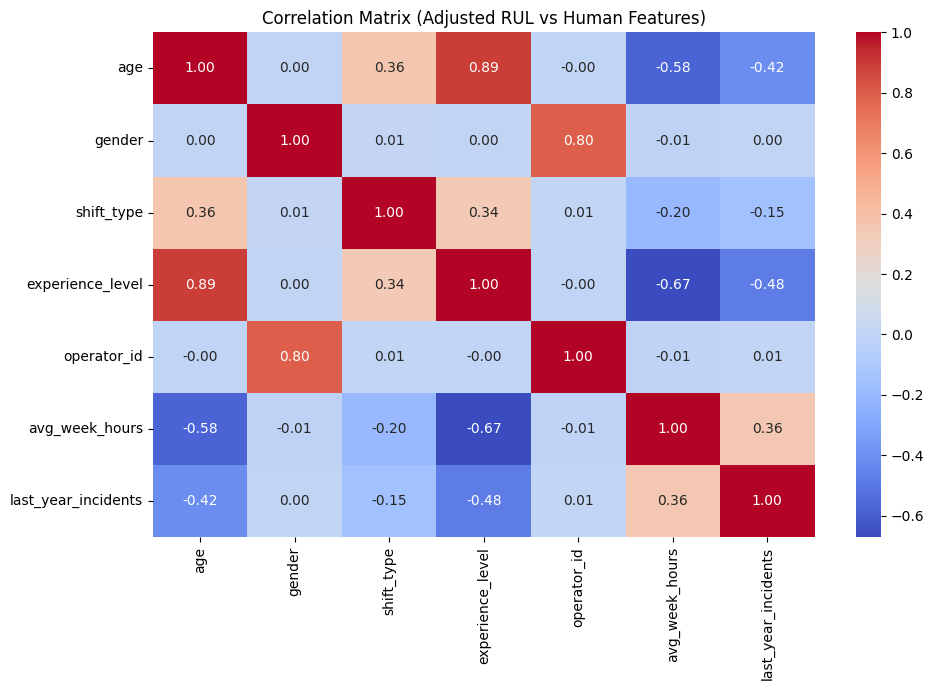

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


train_encoded = train.copy()
train_encoded["gender"] = train_encoded["gender"].map({"Male": 0, "Female": 1})
train_encoded["shift_type"] = train_encoded["shift_type"].map({"Morning": 0, "Afternoon": 1, "Night": 2})
train_encoded["experience_level"] = train_encoded["experience_level"].map({
    "Intern": 0, "Beginner": 1, "Intermediate": 2, "Experienced": 3, "Expert": 4
})


correlation_matrix = train_encoded[[
    "age", "gender", "shift_type", "experience_level",
    "operator_id", "avg_week_hours", "last_year_incidents"
]].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Adjusted RUL vs Human Features)")
plt.tight_layout()
plt.show()

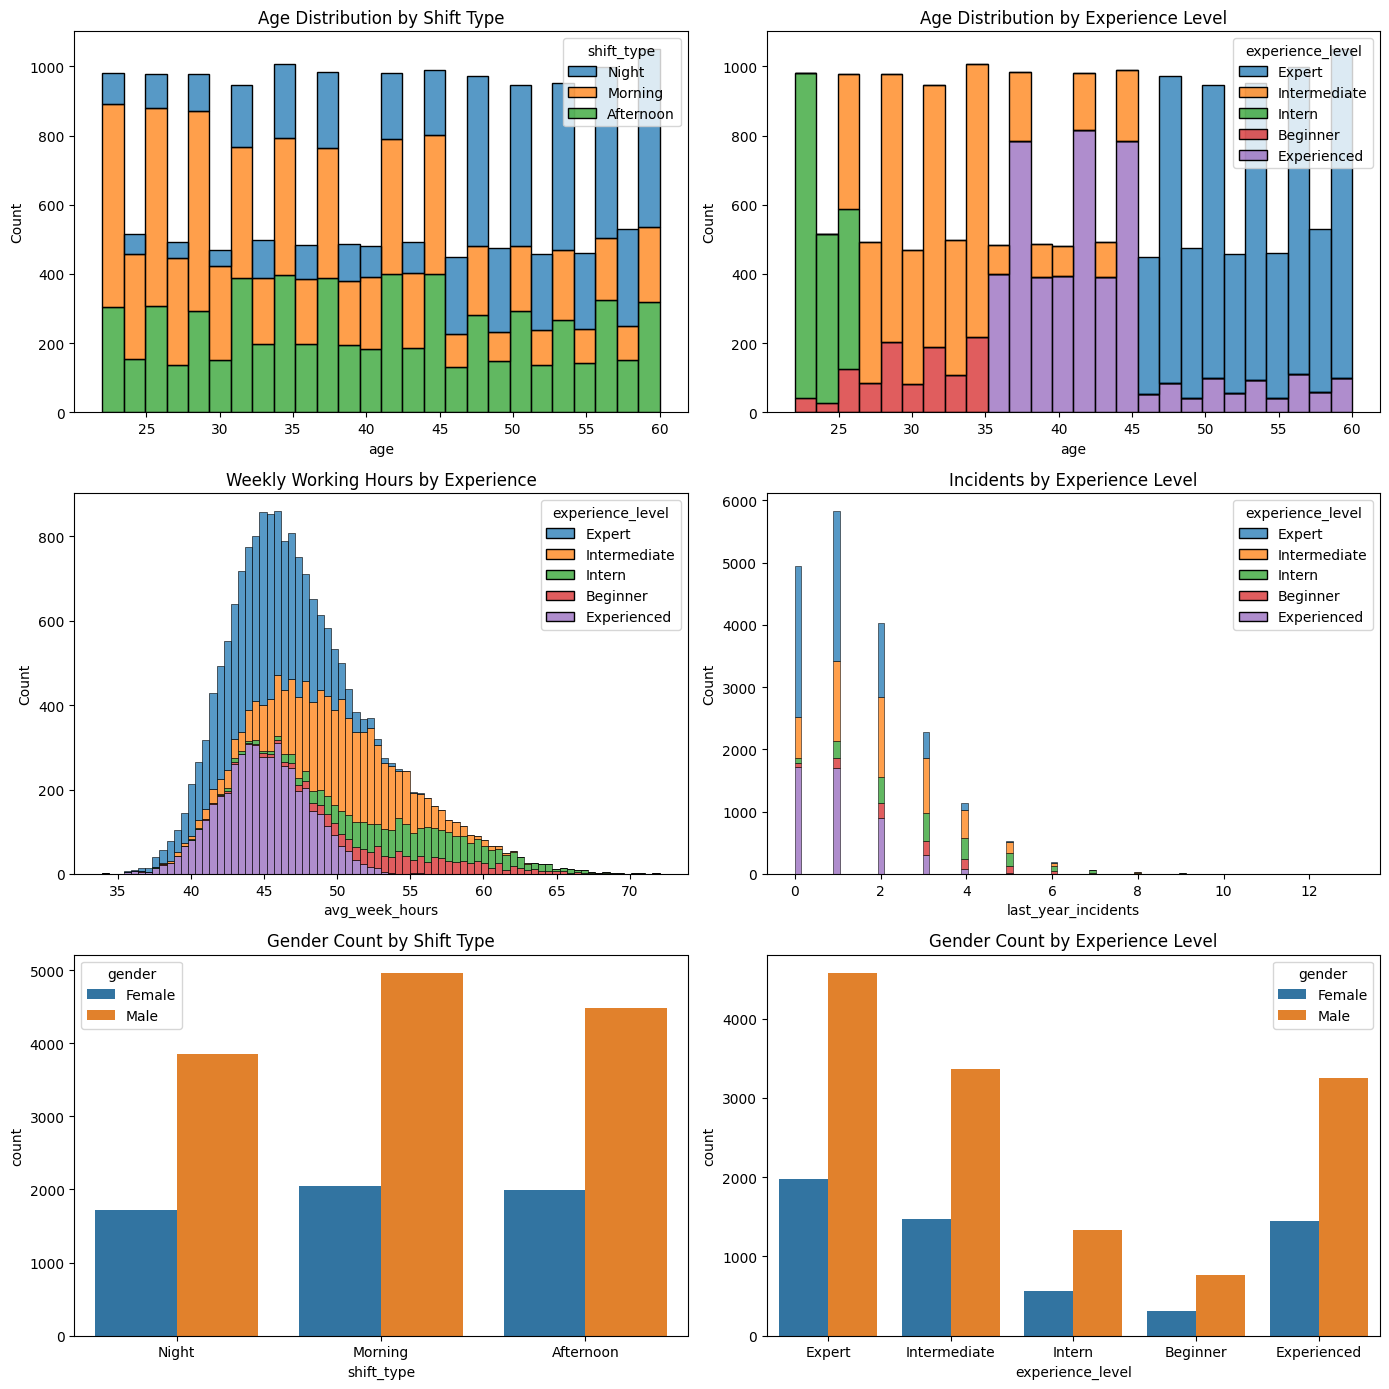

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(14, 14))

sns.histplot(data=train, x="age", hue="shift_type", multiple="stack", ax=axs[0, 0])
axs[0, 0].set_title("Age Distribution by Shift Type")

sns.histplot(data=train, x="age", hue="experience_level", multiple="stack", ax=axs[0, 1])
axs[0, 1].set_title("Age Distribution by Experience Level")

sns.histplot(data=train, x="avg_week_hours", hue="experience_level", multiple="stack", ax=axs[1, 0])
axs[1, 0].set_title("Weekly Working Hours by Experience")

sns.histplot(data=train, x="last_year_incidents", hue="experience_level", multiple="stack", ax=axs[1, 1])
axs[1, 1].set_title("Incidents by Experience Level")

sns.countplot(data=train, x="shift_type", hue="gender", ax=axs[2, 0])
axs[2, 0].set_title("Gender Count by Shift Type")

sns.countplot(data=train, x="experience_level", hue="gender", ax=axs[2, 1])
axs[2, 1].set_title("Gender Count by Experience Level")

plt.tight_layout()
plt.show()

# Random Forest

In [8]:
""" import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data ---
df = pd.read_csv("datasets/shift-data/train_FD001_with_humans.csv")

# --- Prepare features and target ---
X = df.drop(columns=[
    "unit_number", "time_cycles", "adjusted_rul"  # drop original RUL, ID, and timestamp
])
y = df["adjusted_rul"]

# --- One-hot encode categoricals ---
X = pd.get_dummies(X, columns=["shift_type", "experience_level", "gender"], drop_first=True)

# --- Scale numeric features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Split ---
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Train Random Forest ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# --- Predict and evaluate ---
y_pred = rf.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

# --- Plot: Actual vs Predicted ---
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual Adjusted RUL")
plt.ylabel("Predicted Adjusted RUL")
plt.title("Random Forest: Real vs Predicted Adjusted RUL")
plt.grid(True)
plt.tight_layout()
plt.show() """

' import pandas as pd\nimport numpy as np\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# --- Load data ---\ndf = pd.read_csv("datasets/shift-data/train_FD001_with_humans.csv")\n\n# --- Prepare features and target ---\nX = df.drop(columns=[\n    "unit_number", "time_cycles", "adjusted_rul"  # drop original RUL, ID, and timestamp\n])\ny = df["adjusted_rul"]\n\n# --- One-hot encode categoricals ---\nX = pd.get_dummies(X, columns=["shift_type", "experience_level", "gender"], drop_first=True)\n\n# --- Scale numeric features ---\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)\n\n# --- Split ---\nX_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)\n\n# --- Train Random Forest ---\nrf = Rando

# Gradient Boosting

In [9]:
""" import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --- Load data ---
df = pd.read_csv("datasets/shift-data/train_FD001_with_humans.csv")

# --- Features and Target ---
X = df.drop(columns=["unit_number", "time_cycles", "adjusted_rul"])
y = df["adjusted_rul"]

# --- Encode categorical features ---
X = pd.get_dummies(X, columns=["shift_type", "experience_level", "gender"], drop_first=True)

# --- Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train/Test Split ---
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Gradient Boosting Regressor ---
gbr_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
gbr_model.fit(X_train, y_train)

# --- Predict ---
y_pred_gbr = gbr_model.predict(X_val)

# --- Asymmetric Error Evaluation (heavier penalty for overprediction) ---
errors = y_pred_gbr - y_val
asymmetric_errors = np.where(errors > 0, 2 * (errors ** 2), errors ** 2)
rmse = np.sqrt(np.mean(asymmetric_errors))
mae = mean_absolute_error(y_val, y_pred_gbr)
r2 = r2_score(y_val, y_pred_gbr)

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_gbr, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual Adjusted RUL")
plt.ylabel("Predicted Adjusted RUL")
plt.title("Gradient Boost (Asymmetric Loss): Real vs Predicted Adjusted RUL")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"RMSE (Asymmetric): {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}") """

' import pandas as pd\nimport numpy as np\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.ensemble import GradientBoostingRegressor\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\nimport matplotlib.pyplot as plt\n\n# --- Load data ---\ndf = pd.read_csv("datasets/shift-data/train_FD001_with_humans.csv")\n\n# --- Features and Target ---\nX = df.drop(columns=["unit_number", "time_cycles", "adjusted_rul"])\ny = df["adjusted_rul"]\n\n# --- Encode categorical features ---\nX = pd.get_dummies(X, columns=["shift_type", "experience_level", "gender"], drop_first=True)\n\n# --- Scale features ---\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)\n\n# --- Train/Test Split ---\nX_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)\n\n# --- Gradient Boosting Regressor ---\ngbr_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05

# Linear Regression

In [10]:
""" import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("datasets/shift-data/train_FD001_with_humans.csv")

# --- Features and target ---
X = df.drop(columns=["unit_number", "time_cycles", "adjusted_rul"])
y = df["adjusted_rul"]

# --- One-hot encode categorical features ---
X = pd.get_dummies(X, columns=["shift_type", "experience_level", "gender"], drop_first=True)

# --- Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train/Test split ---
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Train Linear Regression ---
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# --- Predict and evaluate ---
y_pred_lr = lr_model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_lr))
r2 = r2_score(y_val, y_pred_lr)

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_lr, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual Adjusted RUL (cycles)")
plt.ylabel("Predicted Adjusted RUL (cycles)")
plt.title("Linear Regression: Real vs Predicted Adjusted RUL")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}") """

' import pandas as pd\nimport numpy as np\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\nimport matplotlib.pyplot as plt\n\n# --- Load dataset ---\ndf = pd.read_csv("datasets/shift-data/train_FD001_with_humans.csv")\n\n# --- Features and target ---\nX = df.drop(columns=["unit_number", "time_cycles", "adjusted_rul"])\ny = df["adjusted_rul"]\n\n# --- One-hot encode categorical features ---\nX = pd.get_dummies(X, columns=["shift_type", "experience_level", "gender"], drop_first=True)\n\n# --- Scale features ---\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)\n\n# --- Train/Test split ---\nX_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)\n\n# --- Train Linear Regression ---\nlr_model = LinearRegression()\nlr_model.fit(X_train, y_train)\n\n# --- P

# MLP

Epoch 1, Train Loss: 6833.50, Val Loss: 2321.64
Epoch 2, Train Loss: 2282.96, Val Loss: 2223.68
Epoch 3, Train Loss: 2242.35, Val Loss: 2187.78
Epoch 4, Train Loss: 2216.28, Val Loss: 2156.53
Epoch 5, Train Loss: 2188.61, Val Loss: 2161.00
Epoch 6, Train Loss: 2193.11, Val Loss: 2167.18
Epoch 7, Train Loss: 2191.20, Val Loss: 2140.71
Epoch 8, Train Loss: 2175.13, Val Loss: 2172.66
Epoch 9, Train Loss: 2155.03, Val Loss: 2145.59
Epoch 10, Train Loss: 2170.70, Val Loss: 2144.69
Epoch 11, Train Loss: 2154.47, Val Loss: 2116.13
Epoch 12, Train Loss: 2157.50, Val Loss: 2114.42
Epoch 13, Train Loss: 2144.36, Val Loss: 2127.08
Epoch 14, Train Loss: 2143.30, Val Loss: 2135.45
Epoch 15, Train Loss: 2140.37, Val Loss: 2101.46
Epoch 16, Train Loss: 2137.23, Val Loss: 2143.08
Epoch 17, Train Loss: 2145.80, Val Loss: 2101.85
Epoch 18, Train Loss: 2149.78, Val Loss: 2131.08
Epoch 19, Train Loss: 2134.00, Val Loss: 2094.04
Epoch 20, Train Loss: 2131.75, Val Loss: 2125.32
Epoch 21, Train Loss: 2132.47

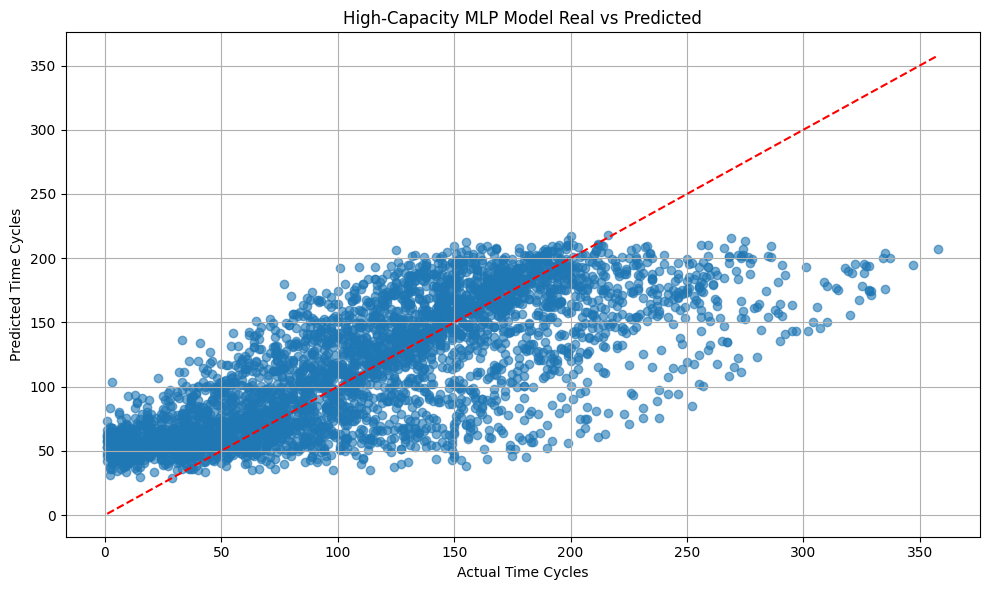

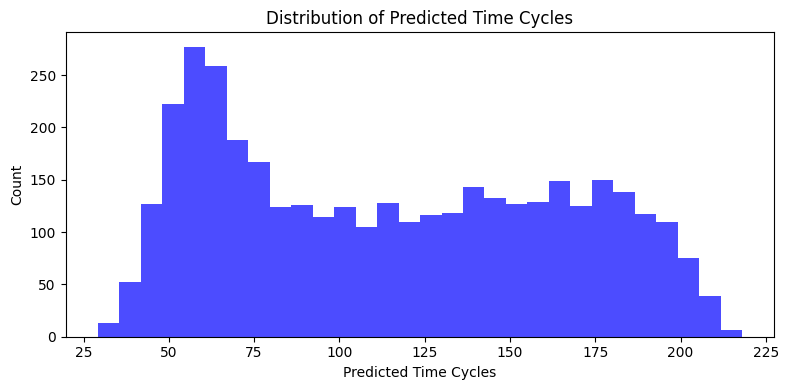

In [11]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# --- Load dataset ---
df = pd.read_csv("datasets/shift-data/train_FD001_with_humans.csv")

# --- Feature Engineering ---
drop_columns = ["op_setting_1", "op_setting_2", "op_setting_3"] + [f"sensor_{i}" for i in range(1, 22)]
X = df.drop(columns=drop_columns + ["time_cycles", "unit_number"])
y = df["time_cycles"]

# Identify numerical columns for normalization
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Create normalized versions of numerical columns (engineered norm features)
for col in numerical_cols:
    mean = X[col].mean()
    std = X[col].std()
    if std != 0:
        X[f"{col}_norm"] = (X[col] - mean) / std
    else:
        X[f"{col}_norm"] = 0.0

# Encode categorical variables
X = pd.get_dummies(X, columns=["shift_type", "experience_level", "gender"], drop_first=True)

# Scale full feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Split ---
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Dataset ---
class ShiftDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(-1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(ShiftDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(ShiftDataset(X_val, y_val), batch_size=64)

# --- Higher-Capacity Model ---
class ImprovedMLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x): return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedMLP(X.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# --- Train loop ---
best_loss = float("inf")
patience, wait = 40, 0

for epoch in range(300):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item()
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}")

    if val_loss < best_loss - 1e-4:
        best_loss = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping")
            break

# --- Evaluate ---
model.eval()
preds, targets = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy().flatten()
        preds.extend(pred)
        targets.extend(yb.numpy().flatten())

mae = mean_absolute_error(targets, preds)
rmse = np.sqrt(mean_squared_error(targets, preds))
r2 = r2_score(targets, preds)
print(f"\nMAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

# --- Scatter Plot ---
plt.figure(figsize=(10, 6))
plt.scatter(targets, preds, alpha=0.6)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
plt.xlabel("Actual Time Cycles")
plt.ylabel("Predicted Time Cycles")
plt.title("High-Capacity MLP Model Real vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Prediction Distribution ---
plt.figure(figsize=(8, 4))
plt.hist(preds, bins=30, color="blue", alpha=0.7)
plt.xlabel("Predicted Time Cycles")
plt.ylabel("Count")
plt.title("Distribution of Predicted Time Cycles")
plt.tight_layout()
plt.show()


## Results

This model predicts engine Remaining Useful Life (RUL) using only synthetic human-related features (shift type, experience level, age, gender).  
Despite limited inputs, the MLP achieved MAE ~33.7, RMSE ~44.4, and R² ~0.58, showing that human factors give a meaningful but partial prediction signal.  
The synthetic dataset was designed to keep a realistic but slightly randomized correlation between human profiles and RUL.


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

# --- Load your dataset ---
df = pd.read_csv("datasets/shift-data/train_FD001_with_humans.csv")

# --- Drop unused columns ---
drop_columns = ["op_setting_1", "op_setting_2", "op_setting_3"] + [f"sensor_{i}" for i in range(1, 22)]
X = df.drop(columns=drop_columns + ["time_cycles", "unit_number"], errors="ignore")

# --- One-hot encode ---
X = pd.get_dummies(X, columns=["shift_type", "experience_level", "gender"], drop_first=False).astype(np.float32)

# --- Pad to 15 features if needed ---
if X.shape[1] < 15:
    X["extra_1"] = 0.0

# --- Load the trained model ---
class ImprovedMLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

model = ImprovedMLP(input_size=15)
model.load_state_dict(torch.load("best-model-shift/mlp_shift_model.pth", map_location=torch.device("cpu")))
model.eval()

# --- Predict ---
X_tensor = torch.tensor(X.values, dtype=torch.float32)
with torch.no_grad():
    predictions = model(X_tensor).numpy().flatten()

# --- Add to DataFrame ---
df["predicted_time_cycles"] = predictions
df["risk_factor"] = pd.cut(
    predictions,
    bins=[-np.inf, 140, 180, np.inf],
    labels=["High", "Medium", "Low"]
)

# --- Save output ---
df.to_csv("train_FD001_with_predictions.csv", index=False)
print("✅ Saved as 'train_FD001_with_predictions.csv'")


✅ Saved as 'train_FD001_with_predictions.csv'
